In [1]:
from pathlib import Path

import numpy as np

from astropy.coordinates import SkyCoord
from astropy.table import Table
from astropy.time import Time
from astropy.timeseries import TimeSeries

from matplotlib import pyplot as plt

from stellarphot.differential_photometry import vsx_mags


In [2]:
folder_with_files = '.'

your_photometry_file = 'UCAC4-combined-data.csv'
comp_stars_file = 'aavso2-UCAC4.csv'
name_of_variable = ''

# Enter the check star label (2 or 3 digit number) below 
check_star_label = '139'

# Our filter names vs filter names in comparison star table
filter_mapping = dict(
    rp='rp',
    B='B',
    V='V',
)

In [3]:
p = Path(folder_with_files)
your_photometry_file = p / your_photometry_file
comp_stars_file = p / comp_stars_file

In [4]:
var_coord = SkyCoord(ra="18:48:26.61", dec="+23:09:04.1", frame="icrs", unit=("hour", "degree"))

vc = dict(coords=var_coord)

In [5]:
your_photometry = Table.read(your_photometry_file)
your_photometry['RA'].unit = 'degree'
your_photometry['Dec'].unit = 'degree'

your_photometry['band'] = your_photometry['filter']

comp_stars = Table.read(comp_stars_file)
comp_stars['RAJ2000'].unit = 'degree'
comp_stars['DEJ2000'].unit = 'degree'



In [6]:
comp_stars_check_only = comp_stars[comp_stars['label'] == int(check_star_label)]
check_star_auid = comp_stars_check_only['auid'][0]

In [7]:
comp_stars_no_check = comp_stars[comp_stars['auid'] != check_star_auid]

## The cell below does just one filter...

In [8]:
this_filter = 'rp'

this_phot = your_photometry[your_photometry['band'] == this_filter]
                                                                                                                                                                                                                                                                                                                                                                                              
this_phot_grp = this_phot.group_by('BJD')

airmass = []
times = []
cal_mag = []
cal_mag_err = []
date_obs = []
for time, rows in zip(this_phot_grp.groups.keys, this_phot_grp.groups):
    mag, err = vsx_mags.calc_vmag(vc, rows, comp_stars_no_check, band=filter_mapping[this_filter], star_data_mag_column=f'mag_inst')
    cal_mag.append(mag)
    cal_mag_err.append(err)
    times.append(time[0])
    date_obs.append(rows['date-obs'][0])
    airmass.append(rows['airmass'][0])
    

In [9]:
table = Table(data=[times, cal_mag, cal_mag_err, airmass, date_obs], names=['time', 'mag', 'err', 'airmass', 'date-obs'])
table['day']  = [np.floor(bjd) for bjd in table['time']]

table = table.group_by('day')

table_grouped = table

In [10]:
table

time,mag,err,airmass,date-obs,day
float64,float64,float64,float64,str23,float64
2460125.7373243696,14.426393650722513,0.21048202518444192,1.127,2023-06-30T05:34:01.560,2460125.0
2460125.738824489,14.326757938031916,0.2369040832079295,1.125,2023-06-30T05:36:11.169,2460125.0
2460125.7403208003,14.249253558443701,0.15794226892649824,1.123,2023-06-30T05:38:20.449,2460125.0
2460125.741881117,14.254429925640814,0.2410264405242706,1.12,2023-06-30T05:40:35.259,2460125.0
2460125.743308573,14.445630080629297,0.23623099011529708,1.119,2023-06-30T05:42:38.590,2460125.0
2460125.744808577,14.269249034504444,0.35127847623226127,1.117,2023-06-30T05:44:48.189,2460125.0
...,...,...,...,...,...
2460156.6760678627,14.468251607410204,0.2494323124549899,1.101,2023-07-31T04:06:09.900,2460156.0
2460156.679594268,14.454406713366854,0.22590605729420712,1.098,2023-07-31T04:11:14.589,2460156.0


(15.564678974954333, 12.26918357235381)

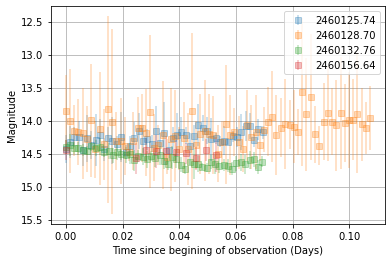

In [28]:
for group in table_grouped.groups: 
    time0 = group['time'][0]
    plt.plot(label = group['day'])
    plt.errorbar(group['time']-time0,group['mag'], yerr=group['err'], fmt = 's', label = f'{time0:.2f}', alpha=0.3)
plt.grid()
plt.ylabel('Magnitude')
plt.xlabel('Time since begining of observation (Days)')
plt.legend()
plt.ylim(*plt.ylim()[::-1])


In [12]:
check = comp_stars[comp_stars['auid'] == check_star_auid]
check_coord = SkyCoord(ra=check['RAJ2000'][0], dec=check['DEJ2000'][0], unit='degree')

In [13]:
your_coords = SkyCoord(ra=your_photometry['RA'], dec=your_photometry['Dec'])

In [14]:
kc = dict(coords=check_coord)

airmass_k = []
times_k = []
cal_mag_k = []
cal_mag_err_k = []
date_obs = []
for time, rows in zip(this_phot_grp.groups.keys, this_phot_grp.groups):
    mag, err = vsx_mags.calc_vmag(kc, rows, comp_stars_no_check, band=filter_mapping[this_filter], star_data_mag_column=f'mag_inst')
    cal_mag_k.append(mag)
    cal_mag_err_k.append(err)
    times_k.append(time[0])
    date_obs.append(rows['date-obs'][0])
    airmass_k.append(rows['airmass'][0])
    
assert times_k == times

In [15]:
table_k = Table(data=[times_k, cal_mag_k, cal_mag_err_k, airmass_k, date_obs], 
                names=['time', 'mag', 'err', 'airmass', 'date-obs'])
table_k['day']  = table['day']

table_k = table_k.group_by('day')

table_grouped_k = table_k
table_k

time,mag,err,airmass,date-obs,day
float64,float64,float64,float64,str23,float64
2460125.7373243696,13.721044308521517,0.21048202518444079,1.127,2023-06-30T05:34:01.560,2460125.0
2460125.738824489,13.725432854095732,0.23690408320792894,1.125,2023-06-30T05:36:11.169,2460125.0
2460125.7403208003,13.77585311675374,0.1579422689264986,1.123,2023-06-30T05:38:20.449,2460125.0
2460125.741881117,13.690738738817632,0.24102644052427105,1.12,2023-06-30T05:40:35.259,2460125.0
2460125.743308573,13.738770881710632,0.23623099011529658,1.119,2023-06-30T05:42:38.590,2460125.0
2460125.744808577,13.78716609453941,0.3512784762322605,1.117,2023-06-30T05:44:48.189,2460125.0
...,...,...,...,...,...
2460156.6760678627,13.704287675449635,0.24943231245499015,1.101,2023-07-31T04:06:09.900,2460156.0
2460156.679594268,13.660903794283971,0.22590605729420649,1.098,2023-07-31T04:11:14.589,2460156.0


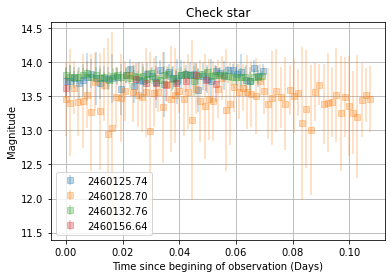

In [27]:
for group in table_grouped_k.groups: 
    time0 = group['time'][0]
    plt.plot(label = group['day'])
    plt.errorbar(group['time']-time0,group['mag'], yerr=group['err'], fmt = 's', label = f'{time0:.2f}', alpha=0.3)
plt.grid()
plt.ylabel('Magnitude')
plt.xlabel('Time since begining of observation (Days)')
plt.title('Check star')
plt.legend()
#plt.ylim(15.2, 14.7)


In [17]:
from stellarphot.io import AAVSOExtendedFileFormat, AAVSOExtendedFileFormatColumns

In [18]:
aef = AAVSOExtendedFileFormat("WTAA")
aef_cols = AAVSOExtendedFileFormatColumns

In [19]:
aef.filter = "SR"
aef.chart = "dhfakfhdajf"
aef.ensemble = True
aef.starid = "UCAC4 ...."
aef.kname = "000-BPQ-388"



In [20]:
table['date-obs-jd'] = Time(table['date-obs'], scale='utc').jd

In [21]:
aef.set_data_columns(table, 
                     {"airmass": aef_cols.AIRMASS, 
                      "mag": aef_cols.VARIABLE_MAG, 
                      "err": aef_cols.VARIABLE_MAG_ERROR, 
                      "date-obs-jd": aef_cols.JD})

In [22]:
aef.set_data_columns(table_k,
                     {"mag": aef_cols.CHECK_STAR_MAG}) 

In [31]:
aef.ensemble = True
aef.notes = "Testing"
wrong_table = aef.to_table()
wrong_table

STARID,DATE,MAGNITUDE,MAGERR,FILTER,TRANS,MTYPE,CNAME,CMAG,KNAME,KMAG,AIRMASS,GROUP,CHART,NOTES
str10,float64,float64,float64,str2,str2,str3,str8,str2,str11,float64,float64,str2,str11,str7
UCAC4 ....,2460125.7319625,14.426393650722513,0.21048202518444192,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.721044308521517,1.127,na,dhfakfhdajf,Testing
UCAC4 ....,2460125.733462604,14.326757938031916,0.2369040832079295,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.725432854095732,1.125,na,dhfakfhdajf,Testing
UCAC4 ....,2460125.7349589006,14.249253558443701,0.15794226892649824,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.77585311675374,1.123,na,dhfakfhdajf,Testing
UCAC4 ....,2460125.736519201,14.254429925640814,0.2410264405242706,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.690738738817632,1.12,na,dhfakfhdajf,Testing
UCAC4 ....,2460125.7379466435,14.445630080629297,0.23623099011529708,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.738770881710632,1.119,na,dhfakfhdajf,Testing
UCAC4 ....,2460125.739446632,14.269249034504444,0.35127847623226127,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.78716609453941,1.117,na,dhfakfhdajf,Testing
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
UCAC4 ....,2460156.670947917,14.468251607410204,0.2494323124549899,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.704287675449635,1.101,na,dhfakfhdajf,Testing
UCAC4 ....,2460156.67447441,14.454406713366854,0.22590605729420712,SR,NO,STD,ENSEMBLE,na,000-BPQ-388,13.660903794283971,1.098,na,dhfakfhdajf,Testing


In [26]:
aef.write('UCAC4-woohoo.csv')